## Imports

In [1]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

## Loading and preparing Data

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
n_samples, h, w = lfw_people.images.shape

In [4]:
X = lfw_people.data
n_features = X.shape[1]

In [5]:
X

array([[254.      , 254.      , 251.66667 , ...,  87.333336,  88.666664,
         86.666664],
       [ 39.666668,  50.333332,  47.      , ..., 117.666664, 115.      ,
        133.66667 ],
       [ 89.333336, 104.      , 126.      , ..., 175.33333 , 183.33333 ,
        183.      ],
       ...,
       [ 86.      ,  80.333336,  74.666664, ...,  44.      ,  49.666668,
         44.666668],
       [ 50.333332,  65.666664,  88.      , ..., 197.      , 179.33333 ,
        166.33333 ],
       [ 30.      ,  27.      ,  32.666668, ...,  35.      ,  35.333332,
         61.      ]], dtype=float32)

In [6]:
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [7]:
y

array([5, 6, 3, ..., 5, 3, 5])

In [8]:
print("n_samples ", n_samples)
print("n_features", n_features)
print("n_classes", n_classes)

n_samples  1288
n_features 1850
n_classes 7


## Splitiing data into test, train datasets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## PCA

In [10]:
n_components = 150

In [11]:
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("Done: TIME TAKEN-> %0.3fs"%(time() - t0))

Done: TIME TAKEN-> 0.504s


In [12]:
eigenfaces = pca.components_.reshape((n_components, h, w))

In [13]:
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Done: TIME TAKEN-> %0.3fs"%(time() - t0))

Done: TIME TAKEN-> 0.040s


## Train a SVM Classification model

In [14]:
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Done: TIME TAKEN-> %0.3fs"%(time() - t0))
print("Best Estimator: ", clf.best_estimator_)

Done: TIME TAKEN-> 58.447s
Best Estimator:  SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [15]:
print("Predicting People's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("Done: TIME TAKEN-> %0.3fs"%(time() - t0))

Predicting People's names on the test set
Done: TIME TAKEN-> 0.129s


## Stats

In [16]:
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.81      0.87      0.84        60
  Donald Rumsfeld       0.85      0.63      0.72        27
    George W Bush       0.84      0.98      0.91       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.97      0.78      0.86        36

         accuracy                           0.85       322
        macro avg       0.87      0.73      0.79       322
     weighted avg       0.86      0.85      0.85       322

[[  7   1   0   5   0   0   0]
 [  2  52   1   4   0   1   0]
 [  0   2  17   8   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   4   0   2   1   8   0]
 [  0   1   2   5   0   0  28]]


## Plots

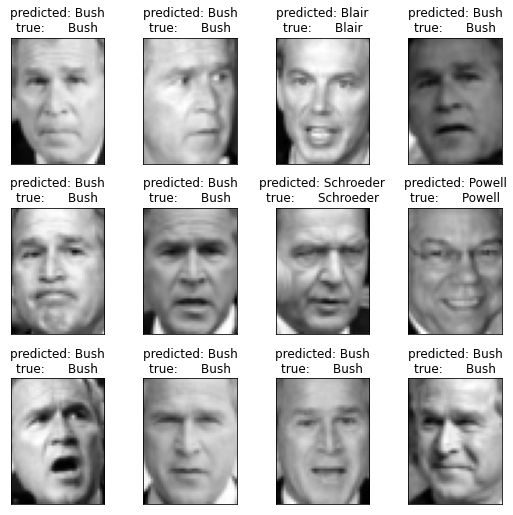

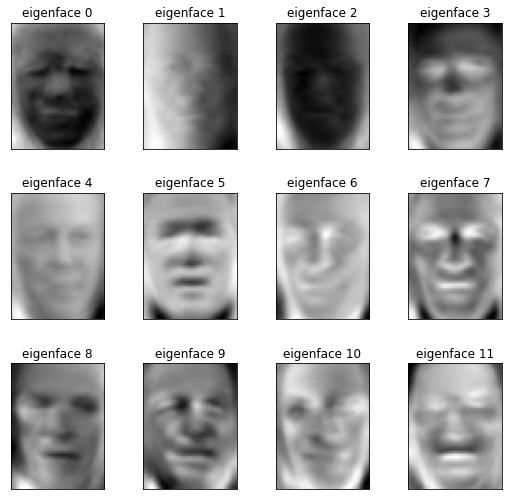

In [18]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()